In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Set Training Label

In [3]:
label = 'NewSim_Type2'

## Find all files

In [4]:
from glob import glob

In [5]:
files_loc = "/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/toy_sim/si-mu-lator/out_files/"

In [6]:
files_bkg = glob(files_loc+'*Muon*bkgr*.h5')

## Open files

In [7]:
import dataprep

In [8]:
dmat, Y, Y_mu, Y_hit = dataprep.make_data_matrix(files_bkg, max_files=100)

(99000, 41)


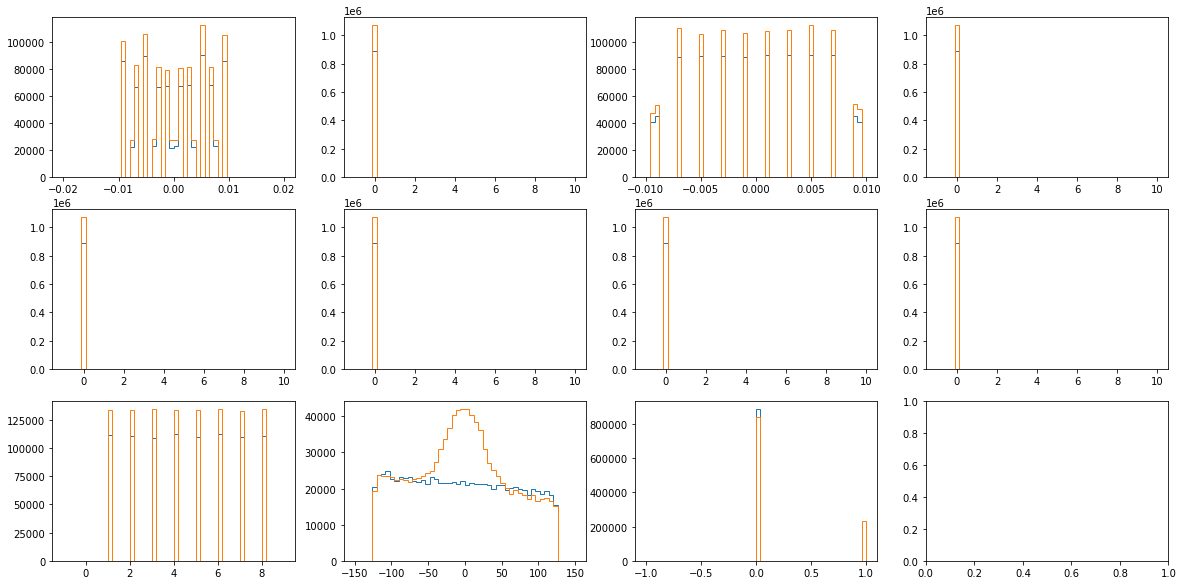

In [21]:
fig, axs = plt.subplots(3, 4, figsize=(20,10))
axs = axs.flatten()

my_mask = dmat[:,:,8] > 0
print(my_mask.shape)

for ivar in range(dmat.shape[2]):
    this_var = dmat[:,:,ivar]
    this_max = np.max(this_var)
    this_min = np.min(this_var)
    
    if ivar == 0:
        this_min = -0.02
        this_max = 0.02
        
    if ivar == 1:
        this_min = -1
        this_max = 10
        
    if ivar == 2:
        this_min = -0.01
        this_max = 0.01
        
    if ivar == 3:
        this_min = -1
        this_max = 10
        
    if ivar == 4:
        this_min = -1
        this_max = 10
        
    if ivar == 5:
        this_min = -1
        this_max = 10
        
    if ivar == 6:
        this_min = -1
        this_max = 10
        
    if ivar == 7:
        this_min = -1
        this_max = 10
        
    if ivar == 8:
        this_min = -1
        this_max = 9
    
    if ivar == 9:
        this_min = -150
        this_max = 150
        
    if this_min == -99:
        this_min = -1
    axs[ivar].hist( this_var[(Y_mu == 0)].flatten()[this_var[(Y_mu == 0)].flatten() != -99], histtype='step', range=(this_min, this_max), bins=50 )
    axs[ivar].hist( this_var[(Y_mu == 1)].flatten()[this_var[(Y_mu == 1)].flatten() != -99], histtype='step', range=(this_min, this_max), bins=50 )
    
plt.show()

In [ ]:
vars_of_interest = np.zeros(11, dtype=bool)
vars_of_interest[0] = 1
vars_of_interest[2] = 1
vars_of_interest[8] = 1
vars_of_interest[9] = 1

In [ ]:
X = dmat[:,:,vars_of_interest]

In [ ]:
Y_mu.sum()

## Define network

In [ ]:
import sys

In [ ]:
sys.path.insert(0, '../')

In [ ]:
import models

In [ ]:
lambs = [0, 1, 10]
mymods = []

for ll in lambs:
    mymodel = models.muon_nn_type2( (X.shape[1],X.shape[2]), ll)
    # mymodel = models.muon_nn_selfatt( (X.shape[1],X.shape[2]), ll)
    mymods.append(mymodel)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
histories = []

for mod,ll in zip(mymods, lambs):
    history = mod.fit( X_train, Y_train,
                        callbacks = [
                                EarlyStopping(monitor='val_loss', patience=1000, verbose=1),
                                ModelCheckpoint(f'weights/{label}_ll_{ll}.h5', monitor='val_loss', verbose=True, save_best_only=True) ],
                        epochs=3000,
                        validation_split = 0.3,
                        batch_size=1024*100,
                        verbose=0
                       )
    
    mod.load_weights(f'weights/{label}_ll_{ll}.h5')
    histories.append(history)

In [ ]:
for history,ll in zip(histories,lambs):
    
    plt.Figure()
    for kk in history.history.keys():
        plt.plot(history.history[kk], label=kk)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Lambda = {ll}')
    plt.savefig(f'plots/{label}_loss_ll_{ll}.pdf')
    plt.show()

In [ ]:
Y_test_hits = Y_test[:,1:]
Y_test_mu = Y_test[:,0]

Y_test_hits_f_mu = Y_test_hits[Y_test_mu==1].flatten()
Y_test_hits_f_nomu = Y_test_hits[Y_test_mu==0].flatten()

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
for mod,ll in zip(mymods,lambs):
    
    Y_pred = mod.predict(X_test, verbose=1)
    Y_pred_hits = Y_pred[:,1:]
    Y_pred_mu = Y_pred[:,0]
    Y_pred_hits_f_mu = Y_pred_hits[Y_test_mu==1].flatten()
    Y_pred_hits_f_nomu = Y_pred_hits[Y_test_mu==0].flatten()
    
    plt.Figure()
    plt.hist(Y_pred_hits_f_mu[Y_test_hits_f_mu==0], histtype='step', bins=50, range=(0,1), 
         label='Muon present, non-muon hits')
    plt.hist(Y_pred_hits_f_mu[Y_test_hits_f_mu==1], histtype='step', bins=50, range=(0,1),
         label='Muon present, muon hits')
    plt.yscale('log')
    plt.title(f'Lambda = {ll}')
    plt.legend()
    plt.savefig(f'plots/{label}_hits_pred_ll_{ll}.pdf')
    plt.show()
    
    plt.Figure()
    plt.hist(Y_pred_mu[Y_test_mu==0], histtype='step', bins=50, range=(0,1))
    plt.hist(Y_pred_mu[Y_test_mu==1], histtype='step', bins=50, range=(0,1))
    plt.yscale('log')
    plt.title(f'Lambda = {ll}')
    plt.savefig(f'plots/{label}_muon_pred_ll_{ll}.pdf')
    plt.show()
    

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8) )
axs = axs.flatten()

coli = 3
icol = 0

for mod,ll in zip(mymods,lambs):
    
    Y_pred = mod.predict(X_test, verbose=1)
    Y_pred_hits = Y_pred[:,1:]
    Y_pred_mu = Y_pred[:,0]
    Y_pred_hits_f_mu = Y_pred_hits[Y_test_mu==1].flatten()
    Y_pred_hits_f_nomu = Y_pred_hits[Y_test_mu==0].flatten()
    
    fpr_hits, tpr_hits, _     = roc_curve(Y_test_hits_f_mu[Y_test_hits_f_mu>-90], Y_pred_hits_f_mu[Y_test_hits_f_mu>-90])
    axs[0].semilogy(tpr_hits, 1./fpr_hits, color=f'C{coli+icol}', label=f'lambda = {ll}')
    
    fpr_mus, tpr_mus, _     = roc_curve(Y_test_mu, Y_pred_mu)
    axs[1].semilogy(tpr_mus, 1./fpr_mus, color=f'C{coli+icol}', label=f'lambda = {ll}')
    
    icol+=1
    
axs[0].set_ylabel('Background hits rejection')
axs[0].set_xlabel('Signal hits efficiency')
axs[0].legend()
axs[0].set_xlim(-0.01, 1.01)
axs[0].set_ylim(0.5, 1e6)

axs[1].set_ylabel('Rejection of events with no muons')
axs[1].set_xlabel('Efficiency of events with muons')
axs[1].set_xlim(0.9,1.01)
axs[1].set_ylim(0.5, 1e5)
axs[1].legend()


plt.savefig(f'plots/{label}_ROCs.pdf', transparent=True)
plt.show()